In [1]:
import math
import os
import torch
from tqdm.auto import tqdm
import networkx as nx
from networkx.algorithms import isomorphism
from torch_geometric import datasets
from torch_geometric.utils import to_networkx
from torch_geometric.utils.convert import from_networkx
import matplotlib.pyplot as plt
import multiprocessing
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader

In [ ]:
class SubgraphDistributionCounts:
    def __init__(self, dataset_list, query_graphs):
        self.dataset_list = dataset_list
        self.query_graphs = query_graphs
        self.dataset_source = {'IMDB-BINARY': 'TUDataset', 'PTC_MR': 'TUDataset', 'PROTEINS': 'TUDataset',
                               'NCI1': 'TUDataset', 'NCI109': 'TUDataset', 'MUTAG': 'TUDataset', 'ENZYMES': 'TUDataset',
                               'DD': 'TUDataset', 'COLLAB': 'TUDataset', 'REDDIT-BINARY': 'TUDataset',
                               'REDDIT-MULTI-5K': 'TUDataset', 'REDDIT-MULTI-12K': 'TUDataset', 'QM9': 'TUDataset',
                               'FIRSTMM_DB': 'TUDataset', 'ZINC': 'TUDataset', 'Cora': 'Planetoid',
                               'CiteSeer': 'Planetoid', 'PubMed': 'Planetoid', 'IMDB-MULTI': 'TUDataset'}
        # compute the number of automorphisms of each query graph
        self.querygraph_automorphisms = [(qg, sum(1 for _ in isomorphism.GraphMatcher(qg, qg).subgraph_isomorphisms_iter())) for qg in self.query_graphs]
        print("Number of automorphism of query graphs: ", [item[1] for item in self.querygraph_automorphisms])
        
    def setup(self):
        # for each dataset(containing many graphs), compute the subgraph counts for each query graph
        for ds in tqdm(self.dataset_list, desc='Datasets', leave=True, position=0):
            assert (ds in self.dataset_source)
            file_path = f'data/ENDataset/{ds}@graphs_le5@undirected@induced.pt'
            if not os.path.exists(file_path):
                raw_data = getattr(datasets, self.dataset_source[ds])(f'data/{self.dataset_source[ds]}', ds)
                # create a pool of processes
                with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
                    data_list = list(tqdm(pool.imap(self.process_single, raw_data), desc=ds, leave=False, position=1, total=len(raw_data)))
                # save to file
                torch.save(data_list, file_path)
                
    def process_single(self, graph):
        graph = to_networkx(graph, to_undirected=True)
        for node in graph.nodes():
            graph.nodes[node]['x'] = [1]
            graph.nodes[node]['y'] = [0] * len(self.query_graphs)
        for index, (qg, am) in enumerate(self.querygraph_automorphisms):
            for i in nx.algorithms.isomorphism.GraphMatcher(graph, qg).subgraph_isomorphisms_iter():
                for k in i.keys():
                    graph.nodes[k]['y'][index] += 1
            for node in graph.nodes():
                graph.nodes[node]['y'][index] /= am
        #convert the graph to torch_geometric.data.Data object
        return from_networkx(graph)

In [ ]:
if __name__ == '__main__':
    # Note: the count is induced subgraph count
    dataset_list = ['REDDIT-MULTI-5K', 'COLLAB', 'DD', 'Cora', 'MUTAG', 'PROTEINS', 'IMDB-MULTI']
    query_graphs = [nx.graph_atlas(index) for index in [6, 7] + list(range(13, 19)) + list(range(29, 32)) + list(range(34, 39)) + list(range(40, 53))]
    SubgraphDistributionCounts(dataset_list, query_graphs).setup()

In [ ]:
def show_distribution(dataset_name):
    #read .pt file
    data = torch.load(f'data/ENDataset/{dataset_name}@graphs_le5@undirected@induced.pt')
    ys = [[] for _ in range(29)]
    for d in data:
        for row in d.y:
            for i, y in enumerate(row):
                ys[i].append(int(y.item()))
    print([max(y) for y in ys])

    # # compute MAE by predicting the mean of each row
    # mae_node = []
    # for i in range(29):
    #     mean_i = sum(ys[i]) / len(ys[i])
    #     mae_i = sum(abs(y - mean_i) for y in ys[i]) / len(ys[i])
    #     mae_node.append(mae_i)
    # print(mae_node)

    # draw the histogram of each row of the ys & the 29 corresponding query graphs respectively
    query_graphs = [nx.graph_atlas(index) for index in [6, 7] + list(range(13, 19)) + list(range(29, 32)) + list(range(34, 39)) + list(range(40, 53))]
    fig, axs = plt.subplots(6, 10, figsize=(50, 30))
    for i in range(29):
        axs[2 * (i // 10), i % 10].hist(ys[i], bins=range(0, 50))
        nx.draw(query_graphs[i], with_labels=True, ax=axs[2 * (i // 10) + 1, i % 10])
    
    # show some graphs in the dataset
    dataset = datasets.TUDataset(root='data/TUDataset', name=dataset_name)
    fig, axs = plt.subplots(6, 8, figsize=(36, 48))
    for i, d in enumerate(dataset[:48]):
        nx.draw(to_networkx(d, to_undirected=True), with_labels=True, ax=axs.flat[i])

show_distribution('MUTAG')

In [2]:
'''
list and download all datasets manually
'''

# ['dblp_ct1', 'dblp_ct2', 'DBLP_v1', 'facebook_ct1', 'facebook_ct2', 'highschool_ct1', 'highschool_ct2', 'infectious_ct1', 'infectious_ct2', 'mit_ct1', 'mit_ct2', 'tumblr_ct1', 'tumblr_ct2'] in 'social networks' cannot be processed
tudataset = {
    'molecules': ['AIDS', 'alchemy_full', 'aspirin', 'benzene', 'BZR', 'BZR_MD', 'COX2', 'COX2_MD', 'DHFR', 'DHFR_MD', 'ER_MD', 'ethanol', 'FRANKENSTEIN', 'malonaldehyde', 'MCF-7', 'MCF-7H', 'MOLT-4', 'MOLT-4H', 'Mutagenicity', 'MUTAG', 'naphthalene', 'NCI1', 'NCI109', 'NCI-H23', 'NCI-H23H', 'OVCAR-8', 'OVCAR-8H', 'P388', 'P388H', 'PC-3', 'PC-3H', 'PTC_FM', 'PTC_FR', 'PTC_MM', 'PTC_MR', 'QM9', 'salicylic_acid', 'SF-295', 'SF-295H', 'SN12C', 'SN12CH', 'SW-620', 'SW-620H', 'toluene', 'Tox21_AhR_training', 'Tox21_AhR_testing', 'Tox21_AhR_evaluation', 'Tox21_AR_training', 'Tox21_AR_testing', 'Tox21_AR_evaluation', 'Tox21_AR-LBD_training', 'Tox21_AR-LBD_testing', 'Tox21_AR-LBD_evaluation', 'Tox21_ARE_training', 'Tox21_ARE_testing', 'Tox21_ARE_evaluation', 'Tox21_aromatase_training', 'Tox21_aromatase_testing', 'Tox21_aromatase_evaluation', 'Tox21_ATAD5_training', 'Tox21_ATAD5_testing', 'Tox21_ATAD5_evaluation', 'Tox21_ER_training', 'Tox21_ER_testing', 'Tox21_ER_evaluation', 'Tox21_ER-LBD_training', 'Tox21_ER-LBD_testing', 'Tox21_ER-LBD_evaluation', 'Tox21_HSE_training', 'Tox21_HSE_testing', 'Tox21_HSE_evaluation', 'Tox21_MMP_training', 'Tox21_MMP_testing', 'Tox21_MMP_evaluation', 'Tox21_p53_training', 'Tox21_p53_testing', 'Tox21_p53_evaluation', 'Tox21_PPAR-gamma_training', 'Tox21_PPAR-gamma_testing', 'Tox21_PPAR-gamma_evaluation', 'UACC257', 'UACC257H', 'uracil', 'Yeast', 'YeastH', 'ZINC_full'], 
    'bioinformatics': ['DD', 'ENZYMES', 'KKI', 'OHSU', 'Peking_1', 'PROTEINS'], 
    'computer vision': ['COIL-DEL', 'COIL-RAG', 'Cuneiform', 'Fingerprint', 'FIRSTMM_DB', 'Letter-high', 'Letter-low', 'Letter-med', 'MSRC_9', 'MSRC_21', 'MSRC_21C'], 
    'social networks': ['COLLAB', 'deezer_ego_nets', 'github_stargazers', 'IMDB-BINARY', 'IMDB-MULTI', 'REDDIT-BINARY', 'REDDIT-MULTI-5K', 'REDDIT-MULTI-12K', 'reddit_threads', 'twitch_egos', 'TWITTER-Real-Graph-Partial'], 
    'synthetic': ['COLORS-3', 'SYNTHETICnew', 'Synthie', 'TRIANGLES']
}
# dataset = datasets.TUDataset(root='data/TUDataset', name=tudataset['synthetic'][3])
# fig, axs = plt.subplots(6, 8, figsize=(36, 48))
# for i, d in enumerate(dataset[:48]):
#     nx.draw(to_networkx(d, to_undirected=True), with_labels=True, ax=axs.flat[i])

planetoid = ['Cora', 'CiteSeer', 'PubMed']
# dataset = datasets.Planetoid(root='data/Planetoid', name=planetoid[2])

ogb = ['ogbg-molhiv', 'ogbg-molpcba', 'ogbg-ppa']
# dataset = PygGraphPropPredDataset(name=ogb[2], root='data/OGB')

In [70]:
'''
build the datasets about molecules, bioinformatics, computer vision, social networks, and citation networks by combining the datasets in the same category
'''
if not os.path.exists('data/Datasets_selected/molecules.pt'):
    # molecules: 20k in total, with 150 or 200 graphs from each related tudataset and 1450, 5k from the first two ogb datasets 
    dataset_molecules = []
    for name in tudataset['molecules']:
        dataset = datasets.TUDataset(root='data/TUDataset', name=name)
        dataset_selected = [to_networkx(d, to_undirected=True) for d in dataset[torch.randperm(len(dataset))[:(150 if len(dataset) < 20000 else 200)]]]
        dataset_molecules += [from_networkx(d.subgraph(max(nx.connected_components(d), key=len))) for d in dataset_selected]
    for name in ogb[:2]:
        alloc = {'ogbg-molhiv': 1450, 'ogbg-molpcba': 4000}
        dataset = PygGraphPropPredDataset(name=name, root='data/OGB')
        dataset_selected = [to_networkx(d, to_undirected=True) for d in dataset[torch.randperm(len(dataset))[:alloc[name]]]]
        dataset_molecules += [from_networkx(d.subgraph(max(nx.connected_components(d), key=len))) for d in dataset_selected]
    torch.save(dataset_molecules, 'data/Datasets_selected/molecules.pt')
    
if not os.path.exists('data/Datasets_selected/bioinformatics.pt'):
    # bioinformatics: 10k in total, 3138 from related tudataset and 6862 from the last ogb dataset
    dataset_bioinformatics = []
    for name in tudataset['bioinformatics']:
        dataset_selected = [to_networkx(d, to_undirected=True) for d in datasets.TUDataset(root='data/TUDataset', name=name)]
        dataset_bioinformatics += [from_networkx(d.subgraph(max(nx.connected_components(d), key=len))) for d in dataset_selected]
    dataset = PygGraphPropPredDataset(name=ogb[2], root='data/OGB')
    dataset_selected = [to_networkx(d, to_undirected=True) for d in dataset[torch.randperm(len(dataset))[:6862]]]
    del dataset
    dataset_bioinformatics += [from_networkx(d.subgraph(max(nx.connected_components(d), key=len))) for d in dataset_selected]
    torch.save(dataset_bioinformatics, 'data/Datasets_selected/bioinformatics.pt')
    
if not os.path.exists('data/Datasets_selected/computer_vision.pt'):
    # computer vision: 1034 in total, only from FIRSTMM_DB and MSRC_* in tudataset
    dataset_computer_vision = []
    for name in ['FIRSTMM_DB', 'MSRC_9', 'MSRC_21', 'MSRC_21C']:
        dataset_selected = [to_networkx(d, to_undirected=True) for d in datasets.TUDataset(root='data/TUDataset', name=name)]
        dataset_computer_vision += [from_networkx(d.subgraph(max(nx.connected_components(d), key=len))) for d in dataset_selected]
    torch.save(dataset_computer_vision, 'data/Datasets_selected/computer_vision.pt')
    
if not os.path.exists('data/Datasets_selected/social_networks.pt'):
    # social networks: 5k in total, 500 from each related tudataset
    dataset_social_networks = []
    for name in tudataset['social networks'][:-1]:
        dataset = datasets.TUDataset(root='data/TUDataset', name=name)
        dataset_selected = [to_networkx(d, to_undirected=True) for d in dataset[torch.randperm(len(dataset))[:500]]]
        dataset_social_networks += [from_networkx(d.subgraph(max(nx.connected_components(d), key=len))) for d in dataset_selected]
    torch.save(dataset_social_networks, 'data/Datasets_selected/social_networks.pt')
    
if not os.path.exists('data/Datasets_selected/citation_networks.pt'):
    # citation networks: 3 in total, all from planetoid dataset
    dataset_selected = [to_networkx(datasets.Planetoid(root='data/Planetoid', name=name).data, to_undirected=True) for name in planetoid]
    dataset_citation_networks = [from_networkx(d.subgraph(max(nx.connected_components(d), key=len))) for d in dataset_selected]
    torch.save(dataset_citation_networks, 'data/Datasets_selected/citation_networks.pt')

C:\Users\27491\anaconda3\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [ ]:
temp = torch.load('data/Datasets_selected/social_networks.pt')
print(len(temp))
#draw the histogram of num_nodes of graphs
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.hist([d.num_nodes for d in temp], bins=range(0, 200))

In [ ]:
graph_size = []
for name in tudataset['molecules']:
    dataset = datasets.TUDataset(root='data/TUDataset', name=name)
    for graph in tqdm(dataset):
        graph_size.append(graph.num_nodes)
for name in ogb[:2]:
    dataset = PygGraphPropPredDataset(name=name, root='data/OGB')
    for graph in (tqdm(dataset)):
        graph_size.append(graph.num_nodes)

for name in tudataset['bioinformatics']:
    dataset = datasets.TUDataset(root='data/TUDataset', name=name)
    for graph in tqdm(dataset):
        graph_size.append(graph.num_nodes)
dataset = PygGraphPropPredDataset(name=ogb[2], root='data/OGB')
for graph in tqdm(dataset):
    graph_size.append(graph.num_nodes)

for name in ['FIRSTMM_DB', 'MSRC_9', 'MSRC_21', 'MSRC_21C']:
    dataset = datasets.TUDataset(root='data/TUDataset', name=name)
    for graph in tqdm(dataset):
        graph_size.append(graph.num_nodes)

for name in tudataset['social networks'][:-1]:
    dataset = datasets.TUDataset(root='data/TUDataset', name=name)
    for graph in tqdm(dataset):
        graph_size.append(graph.num_nodes)

for name in planetoid:
    dataset = datasets.Planetoid(root='data/Planetoid', name=name)
    for graph in tqdm(dataset):
        graph_size.append(graph.num_nodes)

(array([0.000000e+00, 2.500000e+01, 1.900000e+02, 5.390000e+02,
        1.323000e+03, 2.350000e+03, 4.158000e+03, 5.269000e+03,
        7.287000e+03, 1.394453e+06, 1.338740e+05, 7.356200e+04,
        7.156110e+05, 4.420200e+04, 5.501200e+04, 4.036120e+05,
        2.893570e+05, 7.816500e+04, 3.122630e+05, 9.302900e+04,
        9.658500e+04, 2.129390e+05, 9.442200e+04, 9.697300e+04,
        9.537000e+04, 9.389400e+04, 8.799900e+04, 8.099600e+04,
        7.441900e+04, 6.701500e+04, 6.260900e+04, 5.529100e+04,
        5.138500e+04, 4.488200e+04, 4.133000e+04, 3.512300e+04,
        3.219300e+04, 2.712300e+04, 2.613900e+04, 2.449200e+04,
        2.257500e+04, 1.967700e+04, 2.106000e+04, 1.907500e+04,
        1.802300e+04, 1.655000e+04, 1.682100e+04, 1.418000e+04,
        1.385400e+04, 1.241600e+04, 1.365200e+04, 1.217100e+04,
        1.226000e+04, 9.268000e+03, 9.262000e+03, 7.648000e+03,
        8.175000e+03, 7.066000e+03, 7.163000e+03, 6.153000e+03,
        6.645000e+03, 5.401000e+03, 5.94

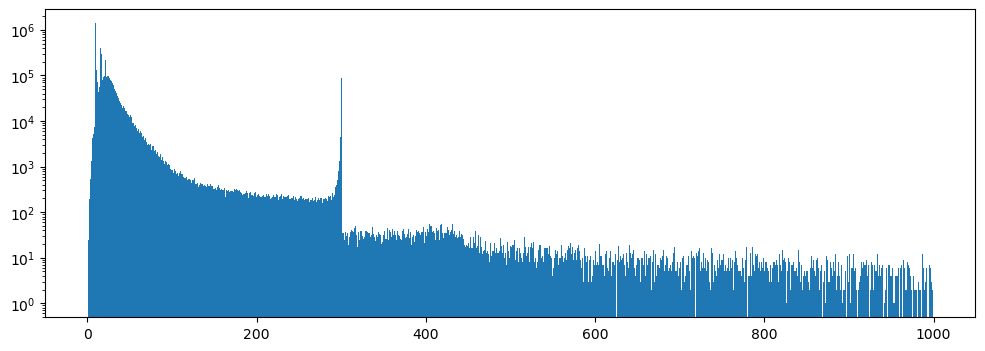

In [4]:
import math
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
# set the y-axis as log-scale
axs.hist(graph_size, bins=range(0, 1000), log=True)

In [5]:
# compute the number of graphs for each node size
graph_size_count = [0] * max(graph_size)
for size in graph_size:
    if size > 0:
        graph_size_count[size - 1] += 1

In [6]:
sample_p = [0] * 1001
for i in range(1000):
    if graph_size_count[i] > 0:
        sample_p[i + 1] = min(100 / graph_size_count[i], 1)

In [ ]:
graphs_selected = [[] for _ in range(1001)]
for name in tudataset['molecules']:
    dataset = datasets.TUDataset(root='data/TUDataset', name=name)
    for graph in tqdm(dataset):
        if 0 < graph.num_nodes < 1001:
            # push the graph to the list with probability sample_p[graph.num_nodes]
            if torch.rand(1).item() < sample_p[graph.num_nodes]:
                graphs_selected[graph.num_nodes].append((graph, 'molecules'))
for name in ogb[:2]:
    dataset = PygGraphPropPredDataset(name=name, root='data/OGB')
    for graph in (tqdm(dataset)):
        if 0 < graph.num_nodes < 1001:
            if torch.rand(1).item() < sample_p[graph.num_nodes]:
                graphs_selected[graph.num_nodes].append((graph, 'molecules'))

for name in tudataset['bioinformatics']:
    dataset = datasets.TUDataset(root='data/TUDataset', name=name)
    for graph in tqdm(dataset):
        if 0 < graph.num_nodes < 1001:
            if torch.rand(1).item() < sample_p[graph.num_nodes]:
                graphs_selected[graph.num_nodes].append((graph, 'bioinformatics'))
dataset = PygGraphPropPredDataset(name=ogb[2], root='data/OGB')
for graph in tqdm(dataset):
    if 0 < graph.num_nodes < 1001:
        if torch.rand(1).item() < sample_p[graph.num_nodes]:
            graphs_selected[graph.num_nodes].append((graph, 'bioinformatics'))

for name in ['FIRSTMM_DB', 'MSRC_9', 'MSRC_21', 'MSRC_21C']:
    dataset = datasets.TUDataset(root='data/TUDataset', name=name)
    for graph in tqdm(dataset):
        if 0 < graph.num_nodes < 1001:
            if torch.rand(1).item() < sample_p[graph.num_nodes]:
                graphs_selected[graph.num_nodes].append((graph, 'computer vision'))

for name in tudataset['social networks'][:-1]:
    dataset = datasets.TUDataset(root='data/TUDataset', name=name)
    for graph in tqdm(dataset):
        if 0 < graph.num_nodes < 1001:
            if torch.rand(1).item() < sample_p[graph.num_nodes]:
                graphs_selected[graph.num_nodes].append((graph, 'social networks'))

for name in planetoid:
    dataset = datasets.Planetoid(root='data/Planetoid', name=name)
    for graph in tqdm(dataset):
        if 0 < graph.num_nodes < 1001:
            if torch.rand(1).item() < sample_p[graph.num_nodes]:
                graphs_selected[graph.num_nodes].append((graph, 'citation networks'))

In [8]:
graphs_selected_copy = graphs_selected.copy()
for i in range(1, 1001):
    if len(graphs_selected_copy[i]) > 20:
        # randomly select 20 graphs for each size i
        graphs_selected_copy[i] = [graphs_selected_copy[i][j] for j in torch.randperm(len(graphs_selected_copy[i]))[:20]]

<BarContainer object of 1001 artists>

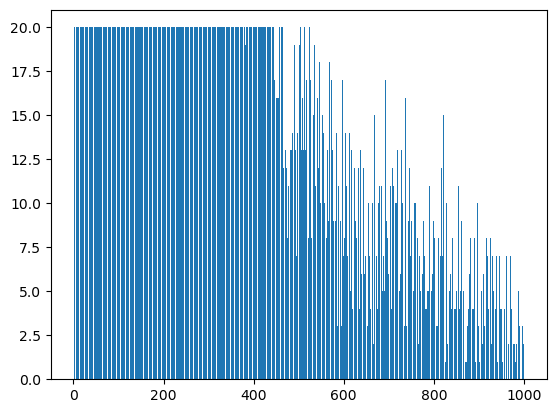

In [9]:
# draw the graph for number of graph of each size
fig, axs = plt.subplots(1, 1)
axs.bar(range(0, 1001), [len(graphs_selected_copy[i]) for i in range(1001)])

In [10]:
print(sum(len(graphs_selected_copy[i]) for i in range(1, 1001)))

13711


In [11]:
# convert the graphs to torch_geometric.data.Data object
graphs_nx = [to_networkx(d[0], to_undirected=True) for i in range(1, 1001) for d in graphs_selected_copy[i]]
graphs_pyg = [from_networkx(g.subgraph(max(nx.connected_components(g), key=len))) for g in graphs_nx]
domains = [d[1] for i in range(1, 1001) for d in graphs_selected_copy[i]]
for i in range(13711):
    graphs_pyg[i].domain = domains[i]
# remove all the graphs with 0 edge
graphs_pyg = [g for g in graphs_pyg if g.num_edges > 0]
# keep only 1 graph with num_nodes=2 and num_edges=1
graphs_pyg = graphs_pyg[:1] + [g for g in graphs_pyg[1:] if not (g.num_nodes == 2 and g.num_edges == 2)]

In [21]:
# save the graphs to file
torch.save(graphs_pyg, 'data/Realworld/realworld.pt')

In [2]:
graphs_pyg = torch.load('data/Realworld/realworld.pt')

In [ ]:
# draw a dot plot with x-axis=domain, y-axis=num_nodes of the graphs in graphs_pyg

# features of the graphs: (#node, #edge, domain) as key, #that graph as value
features = {}
for g in graphs_pyg:
    key = (g.num_nodes, g.num_edges, g.domain)
    if key in features:
        features[key] += 1
    else:
        features[key] = 1
# convert the features to list
features_list = [(key[0], key[1], key[2], value) for key, value in features.items()]

Text(0.5, 0, 'domain')

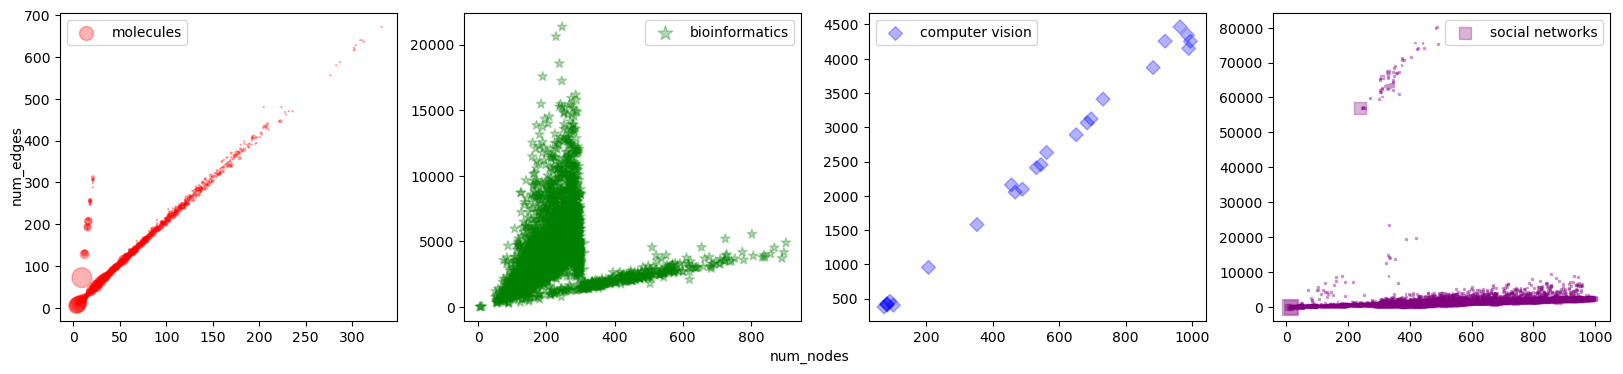

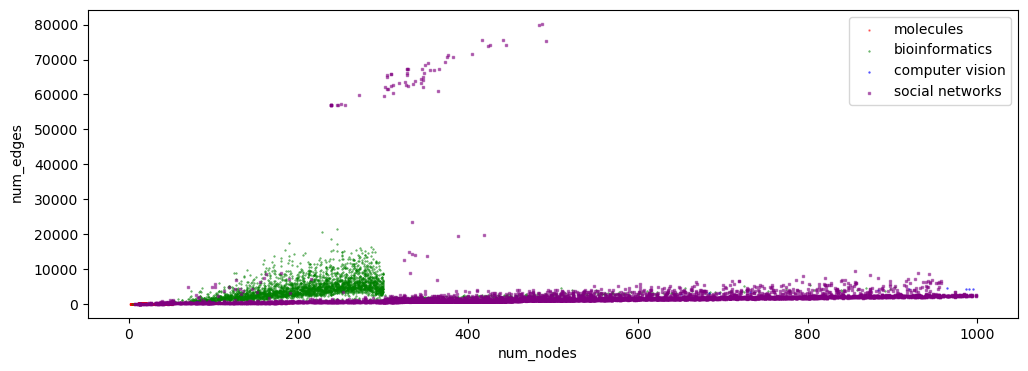

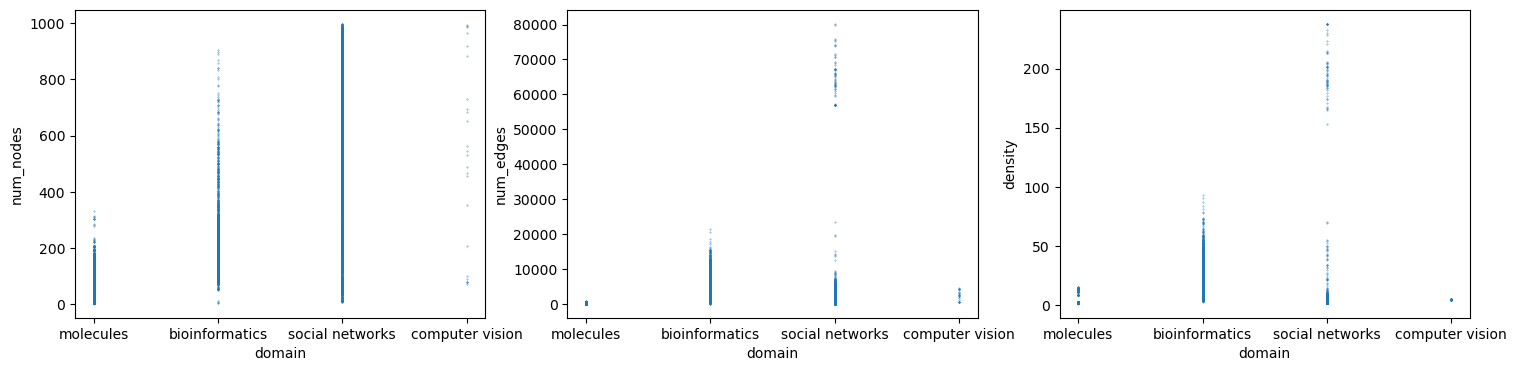

In [89]:
domains = ['molecules', 'bioinformatics', 'computer vision', 'social networks']
# set different shapes for different domains
shapes = ['o', '*', 'D', 's']
# use colormap 'Set3' to represent the domain
# cmap = plt.colormaps['Set1']
cmap = ['red', 'green', 'blue', 'purple']
size_times = [0.5, 50, 50, 2]

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
for index, domain in enumerate(domains):
    x = [f[0] for f in features_list if f[2] == domain]
    y = [f[1] for f in features_list if f[2] == domain]
    s = [size_times[index]*f[3]**2 for f in features_list if f[2] == domain]
    axs[index].scatter(x, y, marker=shapes[index], label=domain, color=cmap[index], s=s, alpha=0.3)
    axs[index].legend()
# set the x-axis and y-axis labels for the whole figure
fig.text(0.5, 0.01, 'num_nodes', ha='center')
fig.text(0.1, 0.5, 'num_edges', va='center', rotation='vertical')

features_list_no_count = []
for key, value in features.items():
    for _ in range(value):
        features_list_no_count.append(key)
color_scheme2 = ['red', 'green', 'blue', 'purple']
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
for index, domain in enumerate(domains):
    x = [f[0] for f in features_list_no_count if f[2] == domain]
    y = [f[1] for f in features_list_no_count if f[2] == domain]
    axs.scatter(x, y, marker=shapes[index], label=domain, color=color_scheme2[index], s=0.55, alpha=0.5)
    axs.legend()
# set the x-axis and y-axis labels for the whole figure
fig.text(0.5, 0.01, 'num_nodes', ha='center')
fig.text(0.06, 0.5, 'num_edges', va='center', rotation='vertical')

# draw the dot plot with x-axis=domain, y-axis=num_nodes/num_edges/density of the graphs in graphs_pyg
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
axs[0].scatter([f[2] for f in features_list_no_count], [f[0] for f in features_list_no_count], s=0.1, alpha=0.8)
axs[0].set_ylabel('num_nodes')
axs[0].set_xlabel('domain')
axs[1].scatter([f[2] for f in features_list_no_count], [f[1] for f in features_list_no_count], s=0.1, alpha=0.8)
axs[1].set_ylabel('num_edges')
axs[1].set_xlabel('domain')
axs[2].scatter([f[2] for f in features_list_no_count], [f[1]/f[0] for f in features_list_no_count], s=0.1, alpha=0.8)
axs[2].set_ylabel('density')
axs[2].set_xlabel('domain')